In [3]:
# ===============================================================
# 1. IMPORTING LIBRARIES
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# ===============================================================
# 2. LOADING DATA
# ===============================================================

train_data = pd.read_csv("Train_data.csv")
test_data = pd.read_csv("Test_data.csv")

print("Train Shape:", train_data.shape)
print("Test Shape :", test_data.shape)

Train Shape: (25192, 42)
Test Shape : (22544, 41)


In [5]:
# ===============================================================
# 3. BASIC INSPECTION
# ===============================================================

print("\nTrain head:")
display(train_data.head())

print("\nTest head:")
display(test_data.head())


Train head:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal



Test head:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


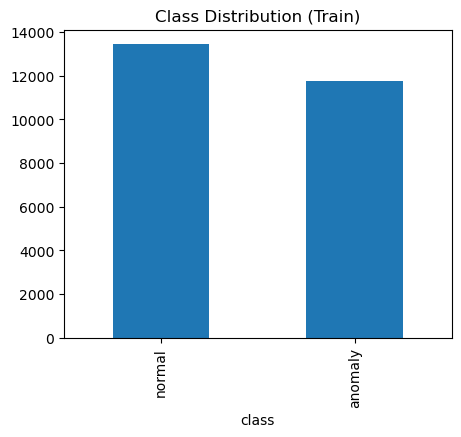

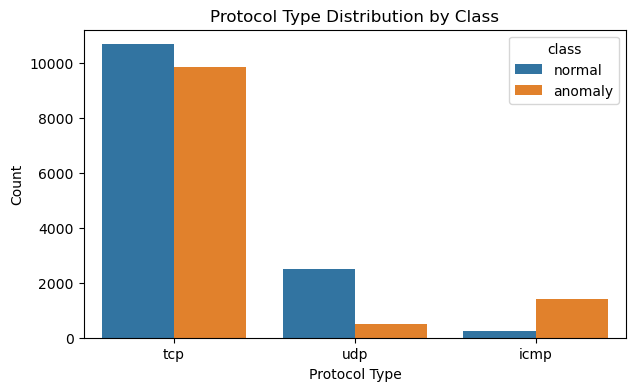

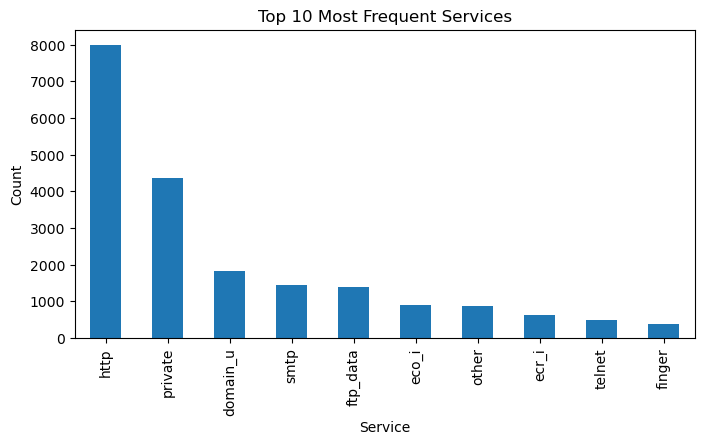

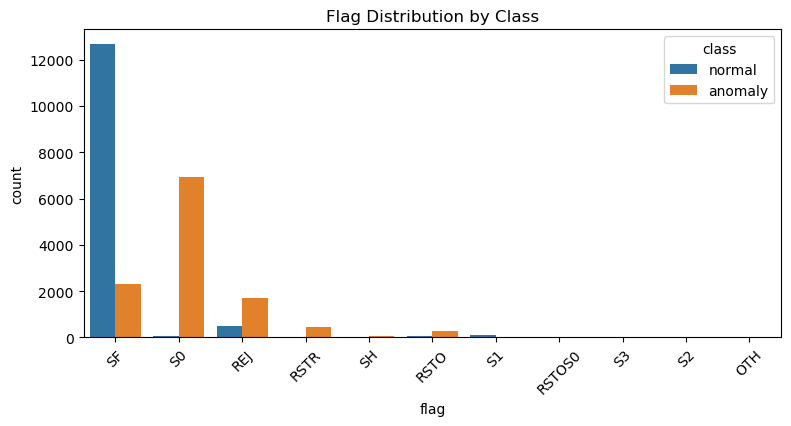

In [28]:
# ===============================================================
# 4. EDA SECTION
# ===============================================================

plt.figure(figsize=(5,4))
train_data["class"].value_counts().plot(kind="bar")
plt.title("Class Distribution (Train)")
plt.show()

# # Categorical distributions
# fig, axes = plt.subplots(1,3, figsize=(15,4))
# sns.countplot(x=train_data['protocol_type'], ax=axes[0])
# axes[0].set_title("Protocol Type")

# sns.countplot(x=train_data['service'], ax=axes[1])
# axes[1].set_title("Service")

# sns.countplot(x=train_data['flag'], ax=axes[2])
# axes[2].set_title("Flag")

# plt.tight_layout()
# plt.show()

# # Correlation heatmap (only numeric)
# plt.figure(figsize=(12,7))
# sns.heatmap(train_data.select_dtypes(include='number').corr(), cmap='coolwarm')
# plt.title("Correlation Heatmap")
# plt.show()

plt.figure(figsize=(7,4))
sns.countplot(data=train_data, x='protocol_type', hue='class')
plt.title("Protocol Type Distribution by Class")
plt.xlabel("Protocol Type")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
train_data['service'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Most Frequent Services")
plt.xlabel("Service")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(9,4))
sns.countplot(data=train_data, x='flag', hue='class')
plt.title("Flag Distribution by Class")
plt.xticks(rotation=45)
plt.show()


In [11]:
# ===============================================================
# 5. SEPARATE FEATURES AND TARGET
# ===============================================================

X_train = train_data.drop('class', axis=1)
y_train = train_data['class']
X_test = test_data.copy()

In [12]:
# ===============================================================
# 6. ENCODING CATEGORICAL COLUMNS
# ===============================================================

categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

In [13]:
# ===============================================================
# 7. FILTER ONLY NORMAL SAMPLES
# ===============================================================

X_train_normal = X_train[y_train == 'normal'].copy()
print("Normal samples:", len(X_train_normal))

Normal samples: 13449


In [14]:
# ===============================================================
# 8. TRAIN–TEST STATISTICAL DIFFERENCE
# ===============================================================

train_mean = X_train_normal.mean()
test_mean  = X_test.mean()

diff = pd.DataFrame({
    "Train_mean": train_mean,
    "Test_mean" : test_mean,
    "Difference": (test_mean - train_mean).abs()
}).sort_values("Difference", ascending=False)

print("\nTop 10 Feature Shifts:")
display(diff.head(10))


Top 10 Feature Shifts:


,Train_mean,Test_mean,Difference
dst_bytes,4400.680645,2056.018808,2344.661838
src_bytes,11394.413637,10395.450231,998.963406
count,22.572905,79.028345,56.455440
dst_host_srv_count,189.429995,140.750532,48.679463
dst_host_count,148.415273,193.869411,45.454138
duration,177.274742,218.859076,41.584334
service,25.118373,32.242681,7.124308
srv_count,27.538256,31.124379,3.586123
flag,8.613057,6.874157,1.738900
num_root,0.462116,0.114665,0.347451


In [15]:
# ===============================================================
# 9. STANDARDIZE DATA
# ===============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled  = scaler.transform(X_test)

In [16]:
# ===============================================================
# 10. TRAIN ONE-CLASS SVM
# ===============================================================

print("\nTraining One-Class SVM...")
model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
model.fit(X_train_scaled)
print("Training complete!")


Training One-Class SVM...
Training complete!


In [17]:
# ===============================================================
# 11. PREDICT
# ===============================================================

y_pred = model.predict(X_test_scaled)
y_pred_labels = np.where(y_pred == -1, "anomaly", "normal")
decision_scores = model.decision_function(X_test_scaled)
test_pred_01 = np.where(y_pred == -1, 1, 0)

results = test_data.copy()
results["Predicted"] = y_pred_labels
results["Score"] = decision_scores

print("\nPrediction Summary:")
print(f"Normal  : {np.sum(y_pred==1)}")
print(f"Anomaly : {np.sum(y_pred==-1)}")


Prediction Summary:
Normal  : 12174
Anomaly : 10370


In [18]:
# ===============================================================
# 12. KERNEL COMPARISON
# ===============================================================

print("\n--- Kernel Comparison ---")
for k in ['linear','poly','rbf']:
    m = OneClassSVM(kernel=k, nu=0.05, gamma='scale')
    m.fit(X_train_scaled)
    preds = m.predict(X_test_scaled)
    print(f"{k:>6s} → {np.mean(preds==-1)*100:.2f}% anomalies")


--- Kernel Comparison ---
linear → 69.89% anomalies
  poly → 33.23% anomalies
   rbf → 46.00% anomalies


In [19]:
# ===============================================================
# 13. NU & GAMMA SWEEP
# ===============================================================

print("\n--- ν & γ Sweep ---")
nus = [0.01, 0.03, 0.05, 0.1]
gammas = ['scale', 0.01, 0.1, 1]

for nu in nus:
    for g in gammas:
        m = OneClassSVM(kernel='rbf', nu=nu, gamma=g)
        m.fit(X_train_scaled)
        preds = m.predict(X_test_scaled)
        print(f"nu={nu}, gamma={g} → {np.mean(preds==-1)*100:.2f}% anomalies")


--- ν & γ Sweep ---
nu=0.01, gamma=scale → 42.82% anomalies
nu=0.01, gamma=0.01 → 34.32% anomalies
nu=0.01, gamma=0.1 → 52.18% anomalies
nu=0.01, gamma=1 → 64.55% anomalies
nu=0.03, gamma=scale → 44.46% anomalies
nu=0.03, gamma=0.01 → 39.08% anomalies
nu=0.03, gamma=0.1 → 52.20% anomalies
nu=0.03, gamma=1 → 64.51% anomalies
nu=0.05, gamma=scale → 46.00% anomalies
nu=0.05, gamma=0.01 → 42.29% anomalies
nu=0.05, gamma=0.1 → 52.78% anomalies
nu=0.05, gamma=1 → 64.66% anomalies
nu=0.1, gamma=scale → 49.97% anomalies
nu=0.1, gamma=0.01 → 45.52% anomalies
nu=0.1, gamma=0.1 → 55.30% anomalies
nu=0.1, gamma=1 → 64.52% anomalies


In [20]:
# ===============================================================
# 14. THRESHOLD SENSITIVITY
# ===============================================================

thresholds = [-0.5, -0.2, 0, 0.2, 0.5]

print("\n--- Threshold Sensitivity ---")
for t in thresholds:
    preds = np.where(decision_scores < t, 1, 0)
    rate = preds.mean()*100
    print(f"Threshold {t}: {rate:.2f}% anomalies")


--- Threshold Sensitivity ---
Threshold -0.5: 45.11% anomalies
Threshold -0.2: 45.53% anomalies
Threshold 0: 46.00% anomalies
Threshold 0.2: 46.45% anomalies
Threshold 0.5: 47.07% anomalies


In [25]:
# Create results DataFrame
results = test_data.copy()
results['Predicted_Class'] = y_pred_labels
results['Anomaly_Score'] = decision_scores

# Print results
print("\n" + "="*70)
print("RESULTS")
print("="*70)
print(f"Total samples: {len(results)}")
print(f"Predicted as Normal: {sum(y_pred == 1)} ({sum(y_pred == 1)/len(y_pred)*100:.2f}%)")
print(f"Predicted as Anomaly: {sum(y_pred == -1)} ({sum(y_pred == -1)/len(y_pred)*100:.2f}%)")

print("\nTop 10 Most Anomalous Samples:")
results.nsmallest(10, 'Anomaly_Score')[['protocol_type', 'service', 'flag',
                                                'src_bytes', 'dst_bytes',
                                                'Predicted_Class', 'Anomaly_Score']]


RESULTS
Total samples: 22544
Predicted as Normal: 12174 (54.00%)
Predicted as Anomaly: 10370 (46.00%)

Top 10 Most Anomalous Samples:


,protocol_type,service,flag,src_bytes,dst_bytes,Predicted_Class,Anomaly_Score
2036,tcp,telnet,SF,277,1089,anomaly,-20.345237
4500,tcp,telnet,SF,277,1087,anomaly,-20.345237
5531,tcp,X11,SF,62825648,90476,anomaly,-20.345237
10620,tcp,ftp,SF,4455,7403,anomaly,-20.345237
11765,tcp,telnet,SF,3061,54942,anomaly,-20.345237
19309,tcp,X11,SF,31645608,207796,anomaly,-20.345237
20734,tcp,telnet,SF,1773,32209,anomaly,-20.345237
21553,tcp,telnet,SF,331,2762,anomaly,-20.345237
12203,tcp,telnet,SF,777,124974,anomaly,-20.345237
20555,tcp,telnet,SF,1713,18570,anomaly,-20.345237


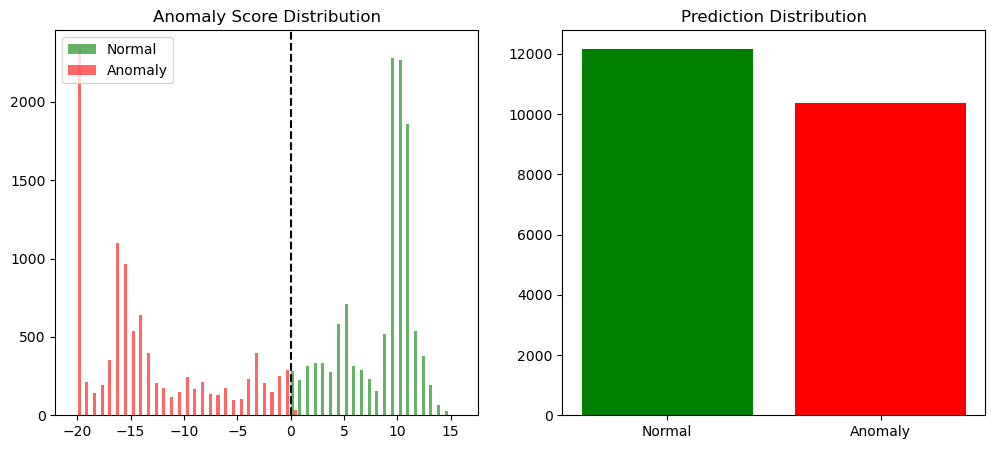

In [21]:
# ===============================================================
# 15. VISUALIZATIONS
# ===============================================================

# Anomaly Score Distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist([decision_scores[y_pred==1], decision_scores[y_pred==-1]],
         bins=50, label=['Normal','Anomaly'],
         color=['green','red'], alpha=0.6)
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Anomaly Score Distribution")
plt.legend()

# Prediction distribution
plt.subplot(1,2,2)
plt.bar(['Normal','Anomaly'], [np.sum(y_pred==1), np.sum(y_pred==-1)],
        color=['green','red'])
plt.title("Prediction Distribution")
plt.show()

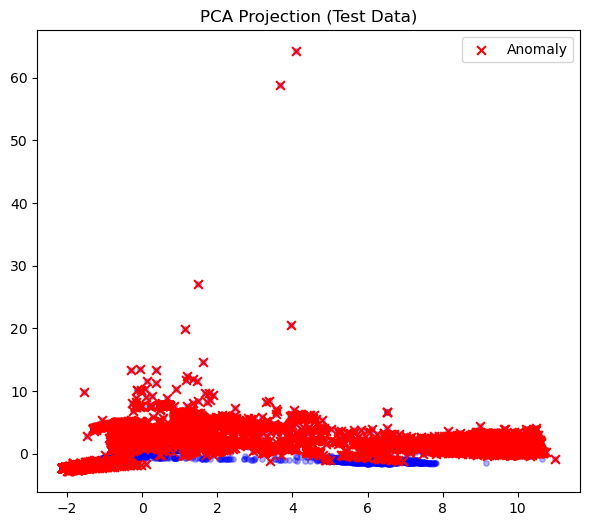

In [22]:
# ===============================================================
# 16. PCA VISUALIZATION
# ===============================================================

pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_scaled)
test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(7,6))
plt.scatter(test_pca[:,0], test_pca[:,1], s=15, alpha=0.3, c='blue')
plt.scatter(test_pca[test_pred_01==1,0], test_pca[test_pred_01==1,1],
            s=40, c='red', marker='x', label='Anomaly')
plt.title("PCA Projection (Test Data)")
plt.legend()
plt.show()

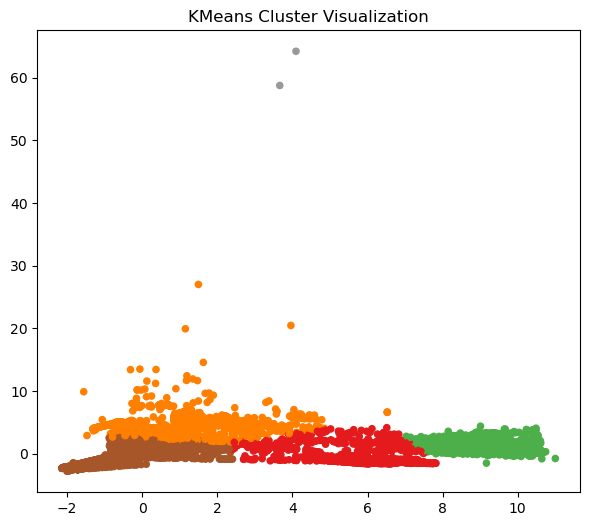

In [23]:
# ===============================================================
# 17. CLUSTERING BEFORE ANOMALY DETECTION
# ===============================================================

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(test_pca)

plt.figure(figsize=(7,6))
plt.scatter(test_pca[:,0], test_pca[:,1],
            c=clusters, cmap='Set1', s=20)
plt.title("KMeans Cluster Visualization")
plt.show()

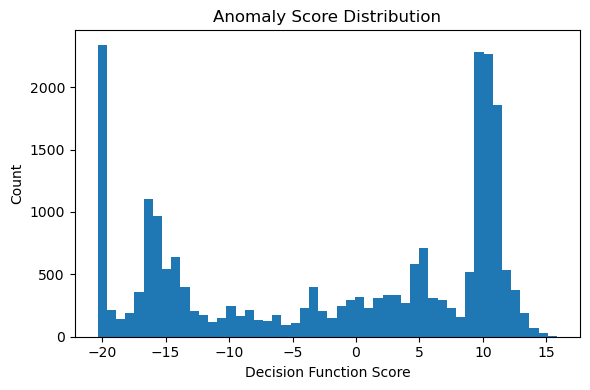

In [26]:
scores = model.decision_function(X_test_scaled)

plt.figure(figsize=(6,4))
plt.hist(scores, bins=50)
plt.title("Anomaly Score Distribution")
plt.xlabel("Decision Function Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [24]:
# ===============================================================
# 18. UNSUPERVISED METRICS
# ===============================================================

print("\n--- UNSUPERVISED METRICS ---")
sil = silhouette_score(X_test_scaled, test_pred_01)
db  = davies_bouldin_score(X_test_scaled, test_pred_01)
ch  = calinski_harabasz_score(X_test_scaled, test_pred_01)

print("Silhouette Score          :", sil)
print("Davies-Bouldin Index      :", db)
print("Calinski-Harabasz Score   :", ch)

# ===============================================================
# END OF COMPLETE PIPELINE
# ===============================================================


--- UNSUPERVISED METRICS ---
Silhouette Score          : 0.3451903727924161
Davies-Bouldin Index      : 1.7753426247947657
Calinski-Harabasz Score   : 4166.268522550655
